## Step 0 : Importing all Libraries 

In [72]:
import yfinance as yf                 # For downloading Data
import matplotlib.pyplot as plt       # For Plotting Data
import numpy as np                    # For numerical Calculations
import pandas as pd                   # For working with DataFrames and Data Processig
import datetime                       # For Datetime Manipulations
import seaborn as sns                 # For Plotting the Graphs 
import opstrat as op                  # For Option Strategy Analysis



## Step 1 : Data Collection and Data Processing 

In [73]:
# Using Apple for Option analyis 
ticker=yf.Ticker('AAPL')
expirations_dates_list=ticker.options

In [74]:
#Downloading Spot Data 
aapl=yf.download(tickers='AAPL')
spot_price=aapl['Close'][-1]  # Storing Recent Apple Stock Price as spot price. To be used in Analysis


[*********************100%%**********************]  1 of 1 completed


### Step 1.a : Data Storage in Data Dictionaries for different Analysis

In [75]:
option = pd.DataFrame()
option_call_put_volume = pd.DataFrame()
option_implied_volatility_call = pd.DataFrame()
option_implied_volatility_put = pd.DataFrame()
option_call_put_OI=pd.DataFrame()
option_chain_data={}

for expiry_date in expirations_dates_list:
    opt = ticker.option_chain(expiry_date)
    option_call_data = opt.calls.copy()
    option_put_data = opt.puts.copy()
    option_data = pd.concat([option_call_data, option_put_data])

    option_data['expirationDate'] = expiry_date
    option = pd.concat([option, option_data], ignore_index=True)

    #Option Chain Compilation

    renamed_columns=['contract Call', 'lastTradeDate_x', 'strike', 'Price Call', 'bid_x',
       'ask_x', 'Price Change Call', 'Price %Change Call', 'Call Volume', 'Call OI',
       'Call IV', 'inTheMoney_x', 'contractSize_x', 'currency_x',
       'contract Put', 'lastTradeDate_y', 'Price Put', 'bid_y', 'ask_y',
       'Price Change Put', 'Price %Change Put', 'Put Volume', 'Put OI',
       'Put IV', 'inTheMoney_y', 'contractSize_y', 'currency_y']
    
    option_chain_data[expiry_date]=pd.merge(left=option_call_data,right=option_put_data,on='strike')
    option_chain_data[expiry_date].columns=renamed_columns

    #Drop columns not required in the analysis
    option_chain_data[expiry_date].drop(['lastTradeDate_x','bid_x',
       'ask_x', 'inTheMoney_x', 'contractSize_x', 'currency_x', 
       'lastTradeDate_y','bid_y', 'ask_y','inTheMoney_y', 'contractSize_y', 'currency_y'],axis=1,inplace=True)
    
    # ReIndexing Columns of Option Chain DataFrame
    option_chain_data[expiry_date] = option_chain_data[expiry_date].reindex(columns=['contract Call',  'Price Call', 'Price Change Call',
       'Price %Change Call', 'Call Volume', 'Call OI', 'Call IV',
       'strike', 'Price Put', 'Price Change Put', 'Price %Change Put',
       'Put Volume', 'Put OI', 'Put IV','contract Put'])


   #  Option Volume Data Compilation
    option_volume = option_call_data[['strike', 'volume']] + option_put_data[['strike', 'volume']]
    option_volume['expirationDate'] = expiry_date
    option_call_put_volume = pd.concat([option_call_put_volume, option_volume], ignore_index=True)

    # Option Implied Volatility Compilation
    option_IV_call = option_call_data[['strike', 'impliedVolatility']].copy()
    option_IV_call['expirationDate'] = expiry_date
    option_implied_volatility_call = pd.concat([option_implied_volatility_call, option_IV_call])

    option_IV_put = option_put_data[['strike', 'impliedVolatility']].copy()
    option_IV_put['expirationDate'] = expiry_date
    option_implied_volatility_put = pd.concat([option_implied_volatility_put, option_IV_put])

    #OI data Compilation
    option_OI = option_call_data[['strike', 'openInterest']] + option_put_data[['strike', 'openInterest']]
    option_OI['expirationDate'] = expiry_date
    option_call_put_OI = pd.concat([option_call_put_OI, option_OI], ignore_index=True)




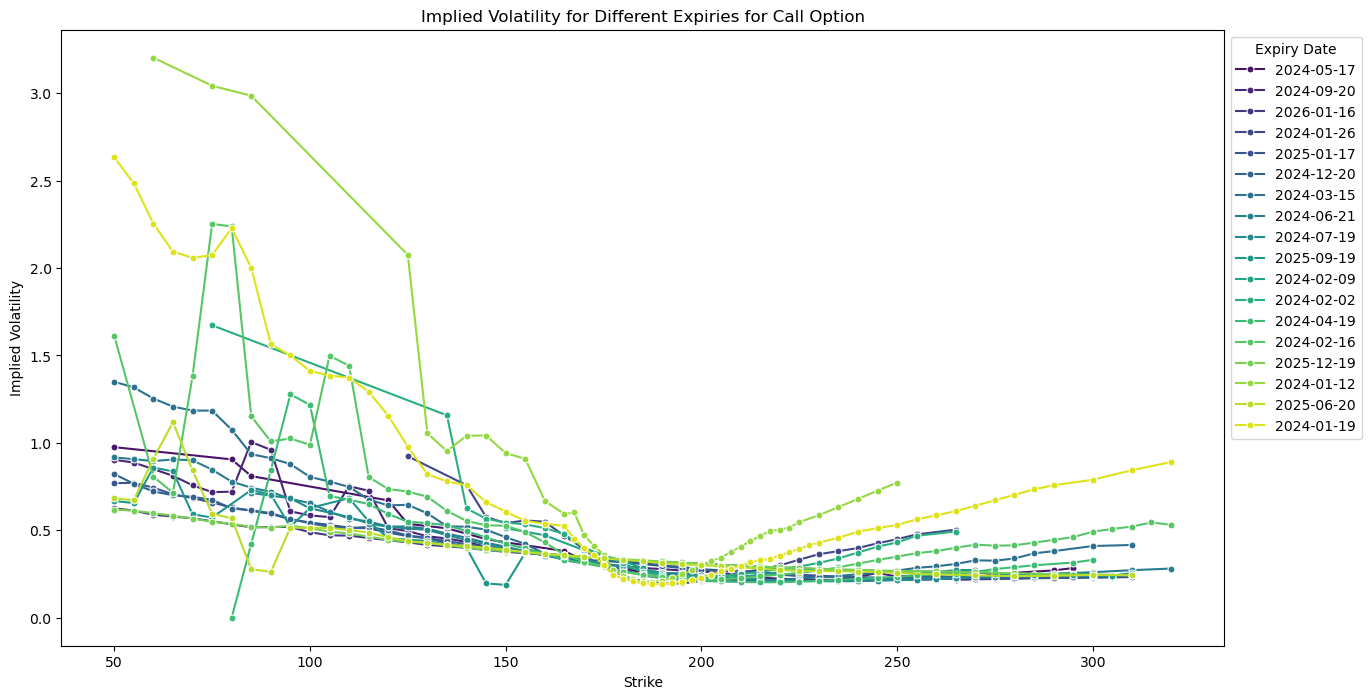

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a color palette for better distinguishability
palette = sns.color_palette('viridis', n_colors=len(set(option_implied_volatility_call['expirationDate'])))

plt.figure(figsize=(15, 8))

for i, expiry_date in enumerate(set(option_implied_volatility_call['expirationDate'])):
    df = option_implied_volatility_call[option_implied_volatility_call['expirationDate'] == expiry_date].copy()
    
    # Smooth out the curves using a rolling mean
    df['smoothed_IV'] = df['impliedVolatility'].rolling(window=2, min_periods=1).mean()
    
    # Plot the smoothed curve with markers and the specified color from the palette
    sns.lineplot(data=df, x='strike', y='smoothed_IV', label=expiry_date, color=palette[i], marker='o', markersize=5)

plt.title('Implied Volatility for Different Expiries for Call Option')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.legend(title='Expiry Date', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()



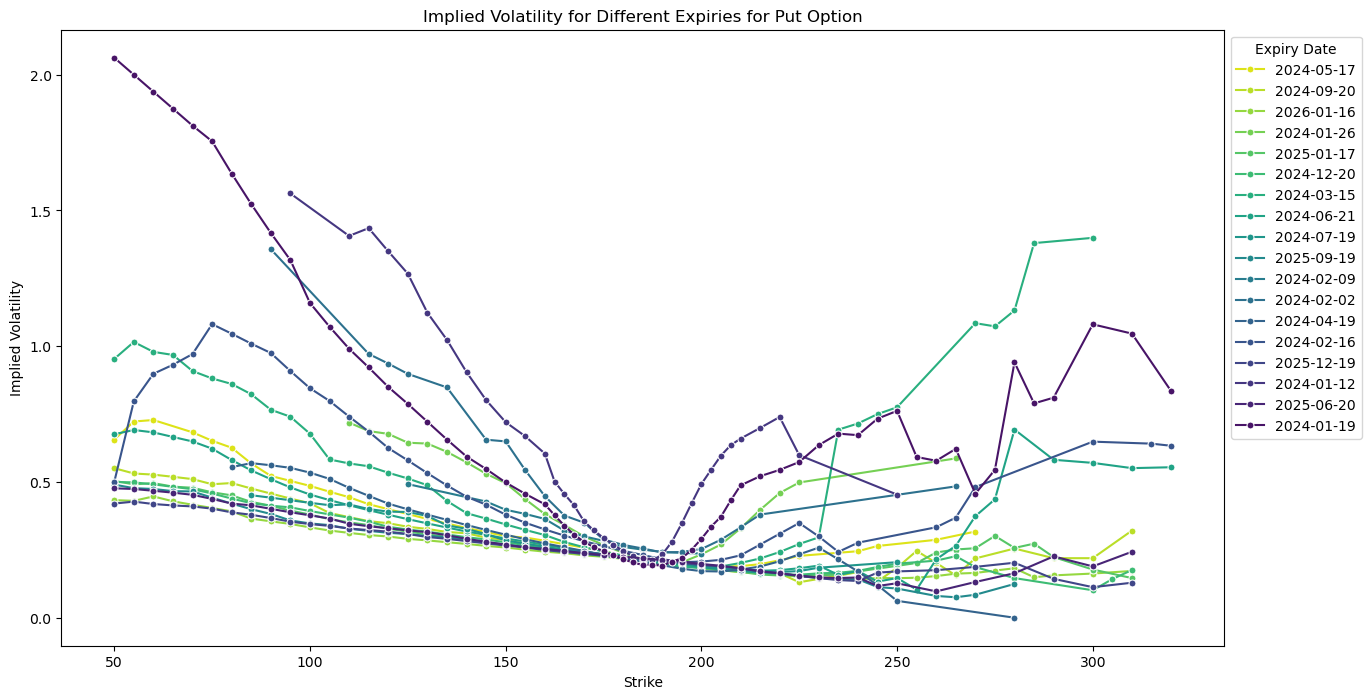

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a reversed color palette for better distinguishability
palette_put = sns.color_palette('viridis', n_colors=len(set(option_implied_volatility_put['expirationDate'])))
reversed_palette_put = list(reversed(palette_put))

plt.figure(figsize=(15, 8))

for i, expiry_date in enumerate(set(option_implied_volatility_put['expirationDate'])):
    df_put = option_implied_volatility_put[option_implied_volatility_put['expirationDate'] == expiry_date].copy()
    
    # Smooth out the curves using a rolling mean
    df_put['smoothed_IV'] = df_put['impliedVolatility'].rolling(window=5, min_periods=1).mean()
    
    # Plot the smoothed curve with markers and the specified color from the reversed palette
    sns.lineplot(data=df_put, x='strike', y='smoothed_IV', label=expiry_date, color=reversed_palette_put[i], marker='o', markersize=5)

plt.title('Implied Volatility for Different Expiries for Put Option')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.legend(title='Expiry Date', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


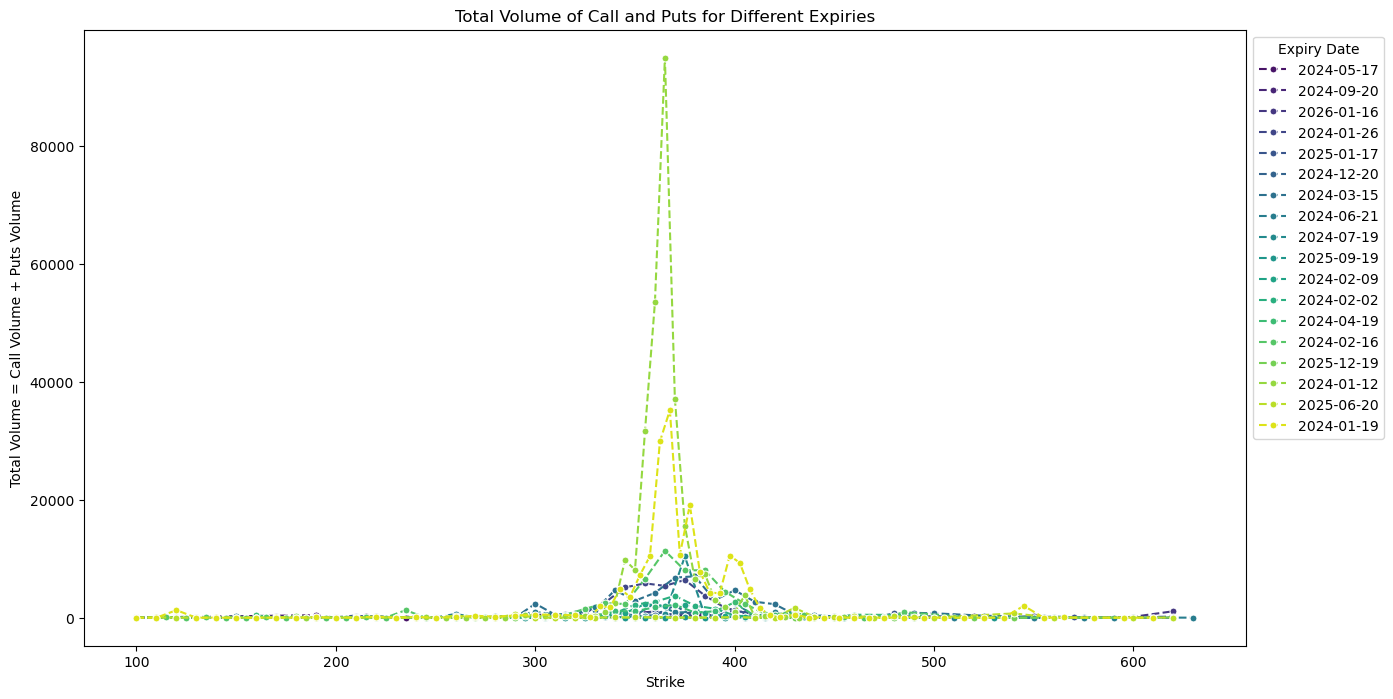

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a reversed color palette for better distinguishability
palette_volume = sns.color_palette('viridis', n_colors=len(set(option_call_put_volume['expirationDate'])))

plt.figure(figsize=(15, 8))

for i, expiry_date in enumerate(set(option_call_put_volume['expirationDate'])):
    df_volume = option_call_put_volume[option_call_put_volume['expirationDate'] == expiry_date].copy()
    
    # Plot histogram with markers and different line styles
    sns.lineplot(data=df_volume, x='strike', y='volume', label=expiry_date, 
                 color=palette_volume[i], marker='o', linestyle='--', markersize=5)

plt.title('Total Volume of Call and Puts for Different Expiries')
plt.xlabel('Strike')
plt.ylabel('Total Volume = Call Volume + Puts Volume')
plt.legend(title='Expiry Date', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


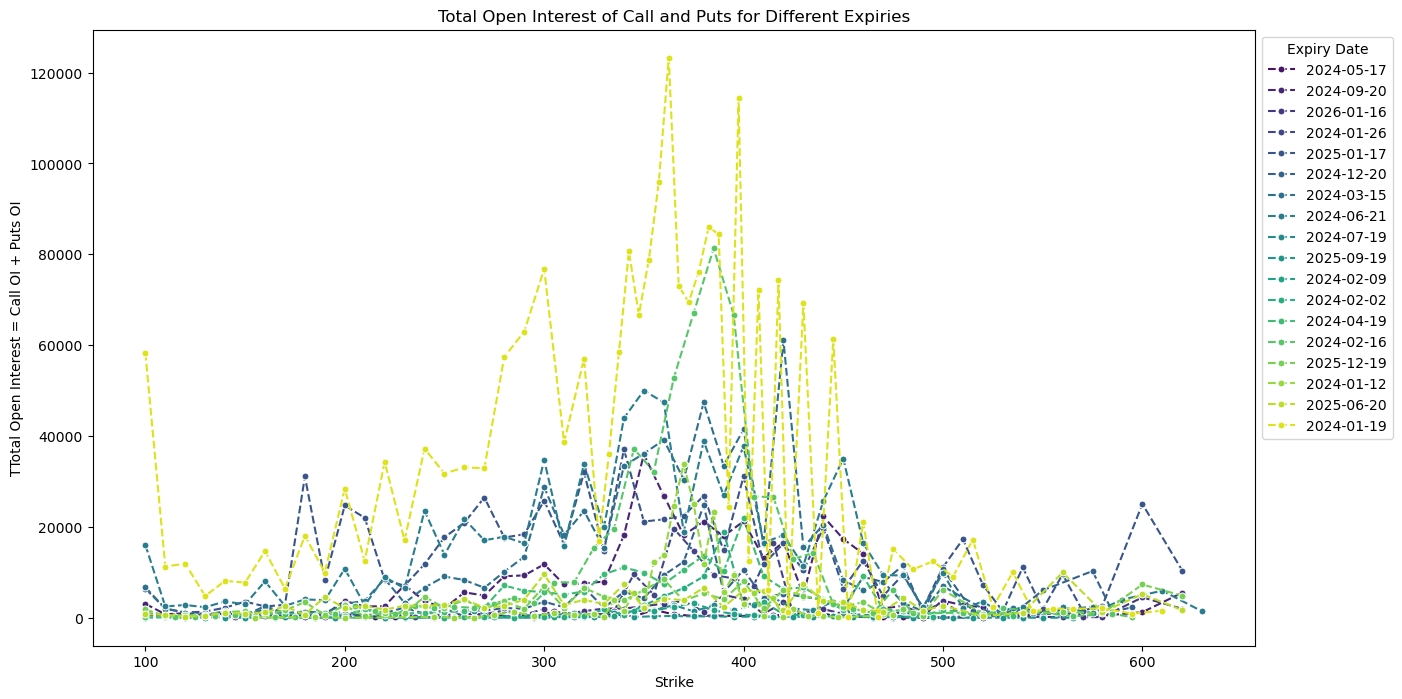

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a reversed color palette for better distinguishability
palette_volume = sns.color_palette('viridis', n_colors=len(set(option_call_put_volume['expirationDate'])))

plt.figure(figsize=(15, 8))

for i, expiry_date in enumerate(set(option_call_put_OI['expirationDate'])):
    df_OI = option_call_put_OI[option_call_put_OI['expirationDate'] == expiry_date].copy()
    
    # Plot histogram with markers and different line styles
    sns.lineplot(data=df_OI, x='strike', y='openInterest', label=expiry_date, 
                 color=palette_volume[i], marker='o', linestyle='--', markersize=5)

plt.title('Total Open Interest of Call and Puts for Different Expiries')
plt.xlabel('Strike')
plt.ylabel('TTotal Open Interest = Call OI + Puts OI')
plt.legend(title='Expiry Date', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [80]:
option['expirationDate'] = pd.to_datetime(option['expirationDate']) + datetime.timedelta(days = 1)
option['Time_to_Expire'] = (option['expirationDate'] - datetime.datetime.today()).dt.days / 365
option['CALL'] = option['contractSymbol'].str[4:].apply(lambda x: "C" in x)
option[['bid', 'ask', 'strike']] = option[['bid', 'ask', 'strike']].apply(pd.to_numeric)
option['mark'] = (option['bid'] + option['ask']) / 2 # Calculate the midpoint of the bid-ask
option = option.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])
option

,contractSymbol,strike,bid,ask,volume,openInterest,impliedVolatility,inTheMoney,expirationDate,Time_to_Expire,CALL,mark
0,AAPL240112C00060000,60.0,120.35,122.10,NaN,2,3.203127,True,2024-01-13,0.013699,True,121.225
1,AAPL240112C00075000,75.0,105.35,107.25,1.0,1,2.882815,True,2024-01-13,0.013699,True,106.300
2,AAPL240112C00085000,85.0,95.40,96.70,NaN,4,3.087893,True,2024-01-13,0.013699,True,96.050
3,AAPL240112C00125000,125.0,55.35,57.05,2.0,3,1.062505,True,2024-01-13,0.013699,True,56.200
4,AAPL240112C00130000,130.0,50.70,51.75,1.0,11,1.046880,True,2024-01-13,0.013699,True,51.225
...,...,...,...,...,...,...,...,...,...,...,...,...
1533,AAPL260116P00280000,280.0,97.60,100.35,1.0,1,0.195626,True,2026-01-17,2.027397,False,98.975
1534,AAPL260116P00285000,285.0,89.35,93.05,NaN,0,0.000010,True,2026-01-17,2.027397,False,91.200
1535,AAPL260116P00290000,290.0,107.05,110.50,1.0,0,0.211281,True,2026-01-17,2.027397,False,108.775
1536,AAPL260116P00300000,300.0,116.95,120.40,3.0,2,0.219734,True,2026-01-17,2.027397,False,118.675


In [81]:
#Building Dictionary of contract 
option_contracts_list={}
option_contracts_list['Call Contracts Tickers']=option[option['CALL']==True][['contractSymbol','strike','expirationDate']]
option_contracts_list['Put Contracts Tickers']=option[option['CALL']==False][['contractSymbol','strike','expirationDate']]


In [82]:
# Creating Dictionary of options Contract hisotrical data
option_contracts_data={}
for contracts in option_contracts_list['Call Contracts Tickers']['contractSymbol'].to_list():
    option_contracts_data['Call Contracts '] = {contracts:yf.download(contracts)}
for contracts in option_contracts_list['Put Contracts Tickers']['contractSymbol'].to_list():
    option_contracts_data['Put Contracts'] = {contracts:yf.download(contracts)}


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

## Step 2 : Building and Visualising Iron Condor Strategy  v/s  Iron Condor with Extra Puts

In [83]:
recent_expiry=expirations_dates_list[0]    # Latest Date of Expiry
recent_expiry

'2024-01-12'

In [84]:
# Checking the spot price 
print("The spot Price of AAPL is ",np.round(spot_price,2))   # AAPL to be changed to general ticker symbol
# Checking the ITM Strike Price 
ITM_stike=0
for x in option_chain_data[recent_expiry]['strike'].to_list():
    if x<spot_price:
        pass
    else:
        ITM_stike = x
        break
print("In The Money  Strike is ",ITM_stike)

The spot Price of AAPL is  181.18
In The Money  Strike is  182.5


In [85]:
option_chain_data[recent_expiry]

,contract Call,Price Call,Price Change Call,Price %Change Call,Call Volume,Call OI,Call IV,strike,Price Put,Price Change Put,Price %Change Put,Put Volume,Put OI,Put IV,contract Put
0,AAPL240112C00125000,55.54,-6.559998,-10.563603,2.0,3,1.062505,125.0,0.01,0.00,0.000000,2.0,19,0.937501,AAPL240112P00125000
1,AAPL240112C00130000,51.69,-18.030003,-25.860590,1.0,11,1.046880,130.0,0.01,0.00,0.000000,15.0,40,0.843752,AAPL240112P00130000
2,AAPL240112C00135000,51.82,0.000000,0.000000,1.0,1,0.859376,135.0,0.01,0.00,0.000000,1.0,552,0.750003,AAPL240112P00135000
3,AAPL240112C00140000,58.15,0.000000,0.000000,15.0,40,1.222660,140.0,0.01,0.00,0.000000,5.0,1340,0.898439,AAPL240112P00140000
4,AAPL240112C00145000,39.42,0.000000,0.000000,1.0,3,0.861330,145.0,0.01,0.00,0.000000,431.0,242,0.578129,AAPL240112P00145000
5,AAPL240112C00150000,30.56,-1.930002,-5.940296,41.0,59,1.021489,150.0,0.01,-0.01,-50.000000,253.0,670,0.531255,AAPL240112P00150000
6,AAPL240112C00155000,27.59,0.130001,0.473420,10.0,445,0.796877,155.0,0.01,-0.01,-50.000000,175.0,569,0.583989,AAPL240112P00155000
7,AAPL240112C00160000,21.36,-0.459999,-2.108154,115.0,86,0.540044,160.0,0.02,-0.02,-50.000000,271.0,751,0.431646,AAPL240112P00160000
8,AAPL240112C00165000,16.10,-1.330000,-7.630522,99.0,72,0.644535,165.0,0.04,-0.03,-42.857143,503.0,3515,0.347663,AAPL240112P00165000
9,AAPL240112C00167500,13.55,-1.500000,-9.966777,6.0,58,0.560063,167.5,0.08,-0.01,-11.111116,2381.0,1399,0.322272,AAPL240112P00167500


### Assumption 
Since the actual delta values are not available we will use the %percentage change of Option Price as substitute. This is because spot price changes equally for calls and puts, so percetage change will be proportional to delta.  

In [86]:
ITM_stike

182.5

From above option chain we will choose call and put options with similar delta. We will start finding such options taking ITM option as the base and move up the stikes in case of call and down in strikes in case of puts, as we have find neary OTM' for selling. Then we will look for deeper OTM options for buying

In [212]:
# Finding the index of ITM in the Option Chain Data
ITM_index=option_chain_data[recent_expiry].index[option_chain_data[recent_expiry]['strike']==ITM_stike].to_list()[0]
delta_diff=option_chain_data[recent_expiry]['Price Change Call']- option_chain_data[recent_expiry]['Price Change Put']

same_delta_option_pairs =[]
for x in range(10):   # Going 10 strike up and down from ITM Strike
    call_delta=option_chain_data[recent_expiry].iloc[ITM_index-x]["Price Change Call"]
    for x in range(10):
        put_delta=option_chain_data[recent_expiry].iloc[ITM_index+x]["Price Change Put"]
        if abs(put_delta-call_delta)<2:
            pair=(ITM_index-x,ITM_index+x)
            (same_delta_option_pairs.append(pair)) 
same_delta_option_pairs=list(set(same_delta_option_pairs))



In [215]:
same_delta_option_pairs.sort()
same_delta_option_pairs

[(8, 22), (9, 21), (10, 20), (11, 19), (12, 18), (13, 17), (14, 16), (15, 15)]

In [214]:
same_delta_option_pairs
delta_pairs=pd.DataFrame()
for pair in same_delta_option_pairs:
    call=option_chain_data[recent_expiry].iloc[pair[0]][['Price Call','strike']]
    put=option_chain_data[recent_expiry].iloc[pair[1]][['Price Put','strike']]
    pair=pd.concat([call,put])
    delta_pairs=pd.concat([delta_pairs,pair],axis=1,ignore_index=True)
delta_pairs=delta_pairs.T
delta_pairs

,Price Call,strike,Price Put,strike
0,16.1,165.0,19.43,200.0
1,13.55,167.5,16.35,197.5
2,11.2,170.0,14.25,195.0
3,8.8,172.5,12.12,192.5
4,6.55,175.0,8.83,190.0
5,4.5,177.5,6.65,187.5
6,2.73,180.0,4.29,185.0
7,1.37,182.5,2.54,182.5


Choosing 7th and 6th int his order only 


Building Iron Condor (4 leged Strategy):

    1. Sell 1 OTM Put (Lower Strike than spot ) 
    2. Sell 1 OTM Call (Higer Strike than spot ) 
    3. Buy 1 OTM Put (More Lower Strike than spot) 
    4. Buy 1 OTM Call (More Higher Strike than spot)

Maximum Profit:  Net Premium Received

Maximum Loss: 
Strike Price of Long Call - Strike Price of Short Call - Net Premium Received or (Strike Price of Short Put - Strike Price of Long Put - Net Premium Received) whichever is higher

Breakeven:
Upper side: Strike Price of Short Call + Net Premium Received Lower side: Strike Price of Short Put - Net Premium Received


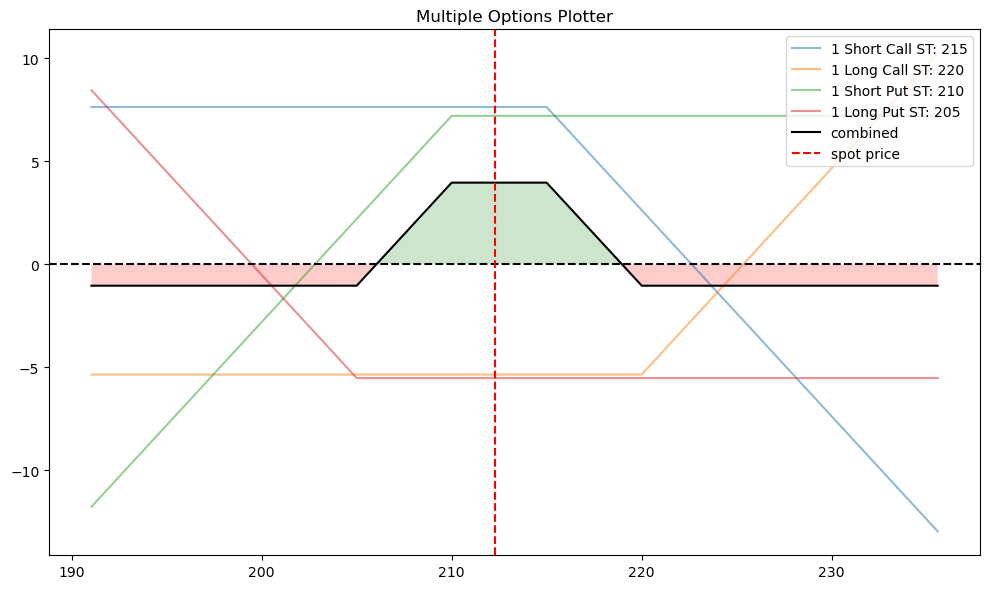

In [243]:
# Iron Condor visualization

op1={'op_type': 'c', 'strike': 215, 'tr_type': 's', 'op_pr': 7.63}
op2={'op_type': 'c', 'strike': 220, 'tr_type': 'b', 'op_pr': 5.35}
op3={'op_type': 'p', 'strike': 210, 'tr_type': 's', 'op_pr': 7.20}
op4={'op_type': 'p', 'strike': 205, 'tr_type': 'b', 'op_pr': 5.52}

op_list=[op1, op2, op3, op4]
op.multi_plotter(spot=212.26,spot_range=10, op_list=op_list)


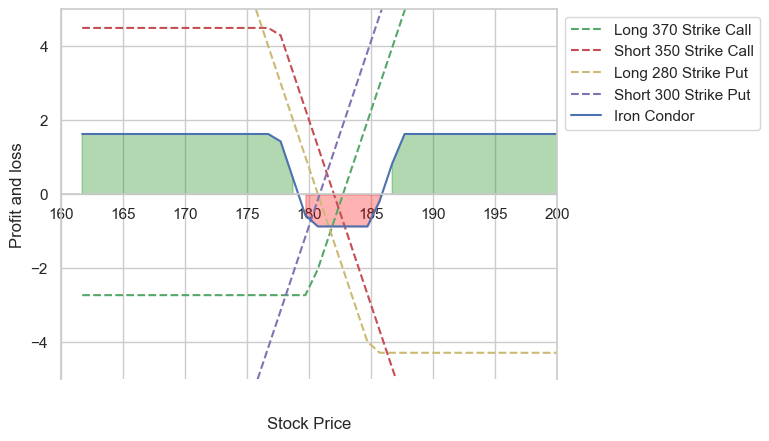

In [251]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def call_payoff(sT, strike_price, premium):
    return np.where(sT > strike_price, sT - strike_price, 0) - premium

def put_payoff(sT, strike_price, premium):
    return np.where(sT < strike_price, strike_price - sT, 0) - premium

spot_price = spot_price

# Long call
strike_price_long_call = 180.0
premium_long_call = 2.73
payoff_long_call = call_payoff(sT, strike_price_long_call, premium_long_call)

# Short call
strike_price_short_call = 177.5
premium_short_call = 4.5
payoff_short_call = call_payoff(sT, strike_price_short_call, premium_short_call) * -1.0

# Long put
strike_price_long_put = 185.0
premium_long_put = 4.29
payoff_long_put = put_payoff(sT, strike_price_long_put, premium_long_put)

# Short put
strike_price_short_put = 187.5
premium_short_put = 6.65
payoff_short_put = put_payoff(sT, strike_price_short_put, premium_short_put) * -1.0

# Iron Condor Plot
payoff = payoff_long_call + payoff_short_call + payoff_long_put + payoff_short_put

# Use Seaborn without whitegrid style
sns.set(style="whitegrid", rc={"axes.grid": False})
fig, ax = plt.subplots()
ax.spines['bottom'].set_position('zero')
ax.plot(sT, payoff_long_call, '--', label='Long 370 Strike Call', color='g')
ax.plot(sT, payoff_short_call, '--', label='Short 350 Strike Call', color='r')
ax.plot(sT, payoff_long_put, '--', label='Long 280 Strike Put', color='y')
ax.plot(sT, payoff_short_put, '--', label='Short 300 Strike Put', color='m')
ax.plot(sT, payoff, label='Iron Condor')

# Fill regions above and below zero with different colors
ax.fill_between(sT, payoff, where=(payoff >= 0), color='green', alpha=0.3)
ax.fill_between(sT, payoff, where=(payoff < 0), color='red', alpha=0.3)

plt.xlabel('Stock Price')
plt.ylabel('Profit and loss')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside
plt.grid()
plt.xlim(160, 200)
plt.ylim(-5, 5)  # Set y-axis range from -5 to 5
ax.xaxis.set_label_coords(0.5, -0.1)  # Adjust the x-axis label position
plt.show()



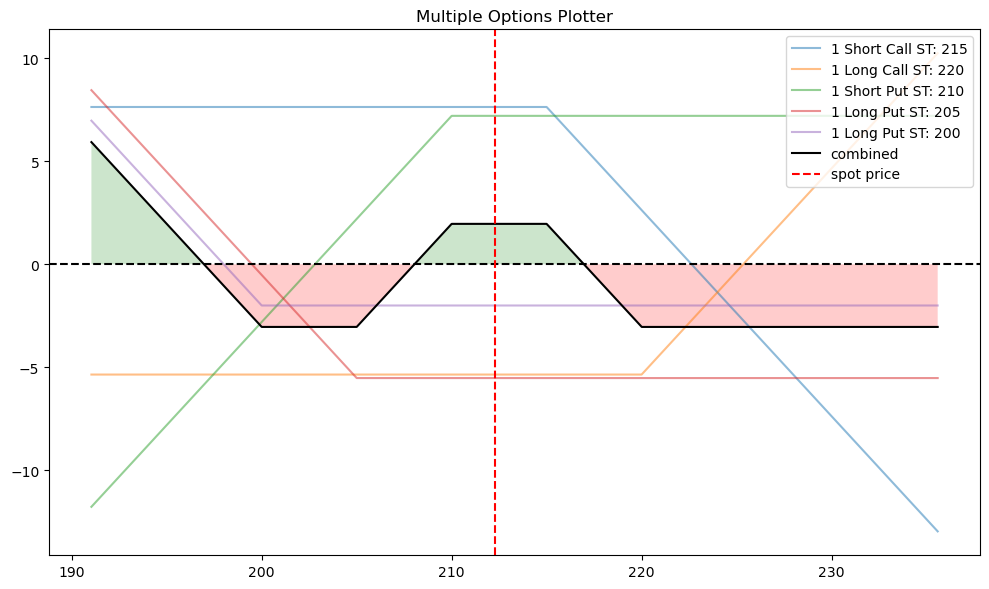

In [91]:
# Iron Condor with extra OTM long put visualization 

op1={'op_type': 'c', 'strike': 215, 'tr_type': 's', 'op_pr': 7.63}
op2={'op_type': 'c', 'strike': 220, 'tr_type': 'b', 'op_pr': 5.35}
op3={'op_type': 'p', 'strike': 210, 'tr_type': 's', 'op_pr': 7.20}
op4={'op_type': 'p', 'strike': 205, 'tr_type': 'b', 'op_pr': 5.52}
op5={'op_type': 'p', 'strike': 200, 'tr_type': 'b', 'op_pr': 2.00}


op_list=[op1, op2, op3, op4, op5]
op.multi_plotter(spot=212.26,spot_range=10, op_list=op_list)

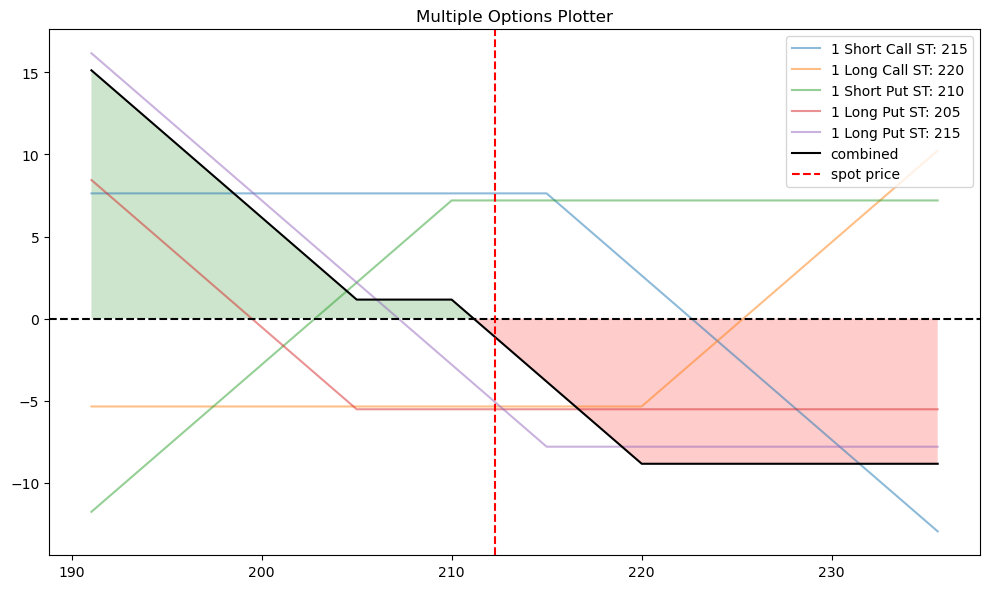

In [92]:
# Iron Condor with extra ATM long put visualization 

op1={'op_type': 'c', 'strike': 215, 'tr_type': 's', 'op_pr': 7.63}
op2={'op_type': 'c', 'strike': 220, 'tr_type': 'b', 'op_pr': 5.35}
op3={'op_type': 'p', 'strike': 210, 'tr_type': 's', 'op_pr': 7.20}
op4={'op_type': 'p', 'strike': 205, 'tr_type': 'b', 'op_pr': 5.52}
op5={'op_type': 'p', 'strike': 215, 'tr_type': 'b', 'op_pr': 7.80}


op_list=[op1, op2, op3, op4, op5]
op.multi_plotter(spot=212.26,spot_range=10, op_list=op_list)

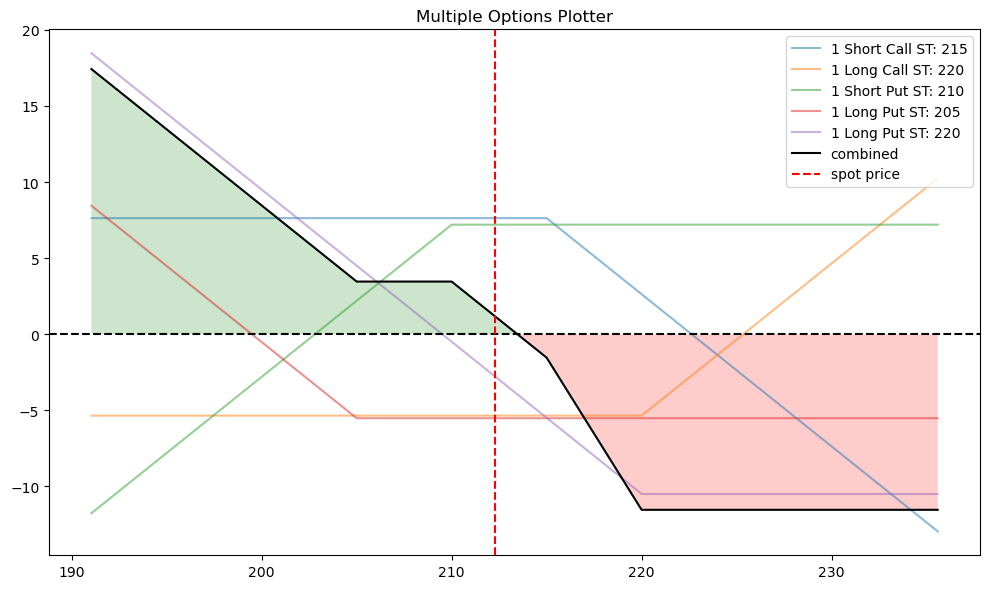

In [93]:
# Iron Condor with extra ITM long put visualization 

op1={'op_type': 'c', 'strike': 215, 'tr_type': 's', 'op_pr': 7.63}
op2={'op_type': 'c', 'strike': 220, 'tr_type': 'b', 'op_pr': 5.35}
op3={'op_type': 'p', 'strike': 210, 'tr_type': 's', 'op_pr': 7.20}
op4={'op_type': 'p', 'strike': 205, 'tr_type': 'b', 'op_pr': 5.52}
op5={'op_type': 'p', 'strike': 220, 'tr_type': 'b', 'op_pr': 10.50}


op_list=[op1, op2, op3, op4, op5]
op.multi_plotter(spot=212.26,spot_range=10, op_list=op_list)

In [94]:
#variables

spot_price = 100

short_OTM_put=2.5    
short_OTM_call=2.5

long_OTM_put=1
long_OTM_call=1


In [95]:
# option chain  data for latest expiry 

data=option_chain_data['2024-01-12'][["lastPrice_x","strike","lastPrice_y"]]


KeyError: "['lastPrice_x', 'lastPrice_y'] not in index"

In [ ]:
spot_price

181.17999267578125

In [ ]:
ATM=list(filter(lambda x: data['strike'].to_list[x] > spot_price, range(len(data['strike'].to_list))))
ATM

TypeError: list indices must be integers or slices, not float

In [ ]:
# strike closest to the spot 
ATM_strike=min(data['strike'].to_list)


TypeError: 'method' object is not iterable

In [ ]:
# Maximum Profit:
# In case stock doesn’t bounce much and stays between my booked positions i.e. between the price of INR 160 and INR 230. Payoff will be as follows:
premium_sum = short_OTM_put+ short_OTM_call - long_OTM_put-long_OTM_call

#Maximum Loss:
# If there is a major volatility or the market bumps due to an uncertain event and made the stock to go up 
premium_sum = short_OTM_put+ short_OTM_call - long_OTM_put-long_OTM_call
